In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
#Reading dataset 
data=pd.read_csv(r"/content/Influencer_data.csv", encoding='latin-1', low_memory=False)

In [ ]:
data.head()

,influencer_username,Text
0,aaroncgshore,crack work morning cheer always help cheer lad...
1,adamcollard,"back natural habitat, work capacity wednesday ..."
2,aliceliveing,feel sorry spending sunday thought good time w...
3,brown.elle,"pretty pink iworkwithprimark, missguided, swit..."
4,charlottedawsy,ere still ere living best lyf espanol phone ph...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(data['Text'])

In [ ]:
kmeans_kwargs = {
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
     }

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

for k in range(2, 12):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(X)
  score = silhouette_score(X, kmeans.labels_)
  silhouette_coefficients.append(score)

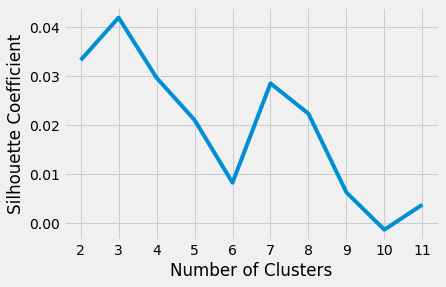

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 12), silhouette_coefficients)
plt.xticks(range(2, 12))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)
labels=kmeans.labels_
Influencer=pd.DataFrame(list(zip(data['influencer_username'],labels)),columns=['influencer_username','cluster'])
print(Influencer.sort_values(by=['cluster']))

   influencer_username  cluster
9       gabbydawnallen        0
24         rogersnipes        0
20      mac_griffiths_        0
1          adamcollard        0
2         aliceliveing        0
27        thebodycoach        1
25       slimmingworld        1
7       courtneydblack        1
28     thefitnesschef_        1
13        jamessmithpt        1
11       itsalwayshana        2
21     mattdoesfitness        3
29        _jackfowler_        3
18         korisampson        3
12         jamesgshore        3
26            sylvijaa        4
3           brown.elle        4
10           ini.helen        5
23        oliviadbowen        6
22             ohpolly        6
0         aaroncgshore        6
17         katiepiper_        6
16        jesswright77        6
15     jessica_rose_uk        6
8   danosborneofficial        6
6           chloe.khan        6
5          chessieking        6
4       charlottedawsy        6
19           lucymeck1        6
14           jesshunt2        6


In [ ]:
new_column = kmeans.fit_predict(X)
data["Cluster"] = new_column
new_influnencer_cluster=data

In [ ]:
new_influnencer_cluster.to_csv('ClusteredInfluencers.csv', index=False)

In [ ]:
#Reading dataset 
brand_data=pd.read_csv(r"/content/data_competitors.csv", encoding='latin-1', low_memory=False)
brand_data.head()

In [ ]:
!pip install -U sentence-transformers

In [ ]:
import itertools
import re
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow_hub as hub
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

In [ ]:
def get_median_similarity(model, ps1, ps2):
    """Calculates the average of the similarity score based on all the combinations of these two lists of texts.
    Using the Universal sentence encoder model."""
    sm_scores = []
    try:
        sembs_1 = model(ps1).numpy()  # Sentence embeddings for the first list of posts
        sembs_2 = model(ps2).numpy()  # Sentence embeddings for the second list of posts

        for semb in sembs_1:
            sm_scores.extend(cosine_similarity([semb], sembs_2))
    except Exception as e:
        print(e)
        # print(ps1)
        # print(ps2)
    return np.median(sm_scores)

In [ ]:
def competitor_influencerCluster_similarity():
    """Do the similarity analysis between all the competitors and influencer clusters"""
    df_competitors = pd.read_csv(r"/content/data_competitors.csv")
    df_influencersclusters = new_influnencer_cluster
    # Dropping the null values if there are any
    df_influencersclusters.dropna(inplace=True)
    df_competitors.dropna(inplace=True)
    df_competitors = df_competitors[df_competitors['platform'] != 'website']

    # Loading the sentence transformers model.
    # bert_model = SentenceTransformer('bert-base-nli-mean-tokens')
    use_model = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')


    # Getting unique values of competitor and influencer names as a list
    cmptr_list = df_competitors['competitor_name'].unique().tolist()
    inflcr_list = df_influencersclusters['Cluster'].unique().tolist()

    final_scores = []
    # Iterating through all the competitors
    for cmptr in cmptr_list:
        # Getting all the posts belonging to the competitor given by 'cmptr'
        cmptr_posts = df_competitors.loc[df_competitors['competitor_name'] == cmptr, 'text'].tolist()
        # Iterating through all the influencers
        for inflcr in inflcr_list:
            # Getting all the posts belonging to the influencer cluster given by 'inflcr'
            inflcr_posts = df_influencersclusters.loc[df_influencersclusters['Cluster'] == inflcr, 'Text'].tolist()
            print('Finding similarity between the competitor', cmptr, ' and the influencer cluster', inflcr, '...')
            # Appending to the list of similarity scores for each combination of competitor and influencer cluster.
            final_scores.append(
                (cmptr, inflcr, get_median_similarity(model=use_model, ps1=cmptr_posts, ps2=inflcr_posts)))

            # Saving the results for every iteration.
            df_similarity = pd.DataFrame(final_scores,
                                         columns=['competitor_name', 'Cluster', 'similarity_score'])
            df_similarity.to_csv('competitor_influencercluster_similarity.csv', index=False)
competitor_influencerCluster_similarity()


In [ ]:
clustered_similarty=pd.read_csv(r"/content/competitor_influencercluster_similarity.csv", encoding='latin-1', low_memory=False)
clustered_similarty

,competitor_name,Cluster,similarity_score
0,bulk,2,0.075245
1,bulk,3,0.083102
2,bulk,6,0.080270
3,bulk,1,0.078671
4,bulk,0,0.071697
...,...,...,...
65,puresport,6,0.117005
66,puresport,1,0.097059
67,puresport,0,0.093631
68,puresport,4,0.090023


In [ ]:
clustered_similarty.sort_values('similarity_score', ascending = False).drop_duplicates('competitor_name')

,competitor_name,Cluster,similarity_score
29,puresport,2,0.117005
8,indisupplements,2,0.114943
11,medterra.international,2,0.111048
19,neurohacker,1,0.102009
23,thenue_co,2,0.089845
16,neat_nutrition,1,0.082721
4,formnutrition,1,0.081510
2,bulk,2,0.080270
25,liveinnermost,1,0.077836
13,motionnutrition,1,0.068733


### Backfill 2020-09-10
- Focus: **Influencer**
- Enhance similarity analysis for Influencer


### Backfill 2020-12-03
- Focus: **Marketing**
- Document market insights for Marketing


### Backfill 2021-01-19
- Focus: **Influencer**
- Improve influencer clustering around Influencer


### Backfill 2021-03-15
- Focus: **Marketing**
- Enhance similarity analysis for Marketing


### Backfill 2021-05-03
- Focus: **Clustering**
- Add visualization for Clustering
